In [3]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle

import os
import pandas as pd

from seaborn import color_palette

# Toolbox
from CBF_tools.toolbox import fmt_data_axis

# Happy pdf for a happy submission without complains in paperplaza, arxiv, etc
font = {'size' : 18}
matplotlib.rc('font', **font)


# Paletas de colores suaves (https://g.co/kgs/4A3q4T)
cake_b = "#d9daff"
cake_r = "#ffdbd9"
cake_y = "#fffbd9"
cake_g = "#dcffd9"

# Global variables
DATA_PATH = "data"
N = 3

In [4]:
# Data load parameters
t0, tf = 140, 400
filenames = ["data_cbf_n1.csv", "data_cbf_n2.csv", "data_cbf_n3.csv"]

# Loading data
dataset = []
for filename in filenames:
    data = pd.read_csv(os.path.join(DATA_PATH, filename), sep="\t")
    data = data.loc[(data["Time"] >= t0) & (data["Time"] <= tf)]
    dataset.append(data)
    print(data.shape)
    print(data.head())
    

# Procesamos los datos y nos guardamos en arrays
time_data = np.zeros((dataset[0].shape[0],N))
omega_data = np.zeros((dataset[0].shape[0],N))
psi_data = np.zeros((dataset[0].shape[0],N,N-1))
prel_data = np.zeros((dataset[0].shape[0],N,2))

for i in range(N):
    data = dataset[i]
    
    # omega safe
    time_data[:,i] = data["Time"].to_list()
    omega_data[:,i] = data["CBF:omega_safe"].to_list()

    # "psi1,psi2" format to dataframe with 2 columns
    psi_df = pd.DataFrame(data["CBF:psi_ref"].str.split(",").to_list())
    pxrel_df = pd.DataFrame(data["CBF:px_rel"].str.split(",").to_list())
    pyrel_df = pd.DataFrame(data["CBF:py_rel"].str.split(",").to_list())
    for k in range(N-1):
        psi_data[:,i,k] = psi_df.loc[:,k].to_list()
        if   i == 0 and k == 0: # prel 1-2
            prel_data[:,0,0] = pxrel_df.loc[:,k].to_list()
            prel_data[:,0,1] = pyrel_df.loc[:,k].to_list()
        elif i == 0 and k == 1: # prel 1-3
            prel_data[:,1,0] = pxrel_df.loc[:,k].to_list()
            prel_data[:,1,1] = pyrel_df.loc[:,k].to_list()
        elif i == 1 and k == 1: # prel 2-3
            prel_data[:,2,0] = pxrel_df.loc[:,k].to_list()
            prel_data[:,2,1] = pyrel_df.loc[:,k].to_list()

prel_norm_data = np.linalg.norm(prel_data, axis=2)
print(np.max(prel_norm_data[:,2]))
print(prel_norm_data.shape)

(1040, 8)
       Time           UTC  GPS_lat(deg)  GPS_long(deg) CBF:psi_ref CBF:py_rel   
537  140.11  16:35:44.540     37.196143      -3.620383       0.,0.      0.,0.  \
538  140.36  16:35:44.790     37.196143      -3.620383       0.,0.      0.,0.   
539  140.61  16:35:45.040     37.196143      -3.620383       0.,0.      0.,0.   
540  140.86  16:35:45.290     37.196143      -3.620383       0.,0.      0.,0.   
541  141.11  16:35:45.540     37.196143      -3.620382       0.,0.      0.,0.   

    CBF:px_rel  CBF:omega_safe  
537      0.,0.             0.0  
538      0.,0.             0.0  
539      0.,0.             0.0  
540      0.,0.             0.0  
541      0.,0.             0.0  
(1040, 8)
        Time           UTC  GPS_lat(deg)  GPS_long(deg)   CBF:psi_ref   
526  140.136  16:35:27.863     37.196094      -3.620358         0.,0.  \
527  140.386  16:35:28.113     37.196094      -3.620358         0.,0.   
528  140.636  16:35:28.363     37.196093      -3.620358         0.,0.   
529

In [5]:
# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

colors = [color_palette()[0],color_palette()[2],color_palette()[3] ]
figsize=(13, 10)
dpi=80

def plot_log(t0_, tf_, ylim=105):
  # Inicialización de las figuras y el grid
  fig = plt.figure(figsize=figsize, dpi=dpi)
  grid = plt.GridSpec(4, 5, hspace=0.4, wspace=0.6)

  # Inicialización de los ejes
  wsafedata_ax = fig.add_subplot(grid[3, :])

  psi1_ax = fig.add_subplot(grid[0, :], xticklabels=[])
  psi2_ax = fig.add_subplot(grid[1, :], xticklabels=[])
  psi3_ax = fig.add_subplot(grid[2, :], xticklabels=[])
  psi_axis = [psi1_ax, psi2_ax, psi3_ax]

  # Se da formato a los ejes
  fmt_data_axis(wsafedata_ax, r"$u_{safe}$ (rad/s)", r"$t$ [s]", ylim=[-1,6], xlim=[t0_,tf_])

  fmt_data_axis(psi1_ax, r"$\psi_1(x,t)$", xlim=[t0_,tf_], ylim=[-5,ylim])
  fmt_data_axis(psi2_ax, r"$\psi_2(x,t)$", xlim=[t0_,tf_], ylim=[-5,ylim])
  fmt_data_axis(psi3_ax, r"$\psi_3(x,t)$", xlim=[t0_,tf_], ylim=[-5,ylim])

  # Background color
  psi1_ax.patch.set_facecolor(cake_b)
  psi2_ax.patch.set_facecolor(cake_g)
  psi3_ax.patch.set_facecolor(cake_r)

  ## Data axis ----------------
  for i in range(N):
    time_vec = time_data[:,i]

    # Zero lines
    wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

    # Plotting data
    color = colors[i]
    wsafedata_ax.plot(time_vec, omega_data[:,i], c=color, lw=1.2)

    for k in range(N-1):
      id = (i+k+1) % 3
      color = colors[id]
      psi_axis[i].plot(time_vec, psi_data[:,i,k], c=color, lw=1.2)
      psi_axis[i].axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

  plt.show()

def plot_prel(t0_, tf_, figsize=(10,10)):
  # Inicialización de las figuras y el grid
  fig = plt.figure(figsize=figsize, dpi=dpi)
  grid = plt.GridSpec(1, 1, hspace=0.4, wspace=0.4)

  # Inicialización de los ejes
  prel_ax = fig.add_subplot(grid[:, :])
  fmt_data_axis(prel_ax, r"$||p_{ij}||$ [m]", "t [s]", xlim=[t0_,tf_], ylim=[0,25])

  # Graficamos
  legend_labels = ["1-2", "1-3", "2-3"]
  line_styles = ["-", "--", "-"]
  colors = [color_palette()[0],color_palette()[0],color_palette()[2]]
  time_vec = time_data[:,0]

  prel_ax.axhline(2, c="r", ls="--", lw=1.6, zorder=0) 
  prel_ax.axhline(2, c="r", ls="--", lw=1.6, zorder=0) 
  prel_ax.add_patch(Rectangle((t0_, 1), tf_-t0_, 2,
                    facecolor = 'red', fill=True, lw=0, alpha=0.2))
  
  prel_ax.text(tf_+0.3, 1.8, r"r = 2", color="red")
  
  for i in range(N):
    prel_ax.plot(time_vec, prel_norm_data[:,i], lw=1.2, label=legend_labels[i],
                 ls=line_styles[i], c=colors[i])

  plt.legend()
  plt.show()
  

# Plotting different intervals of the experiment

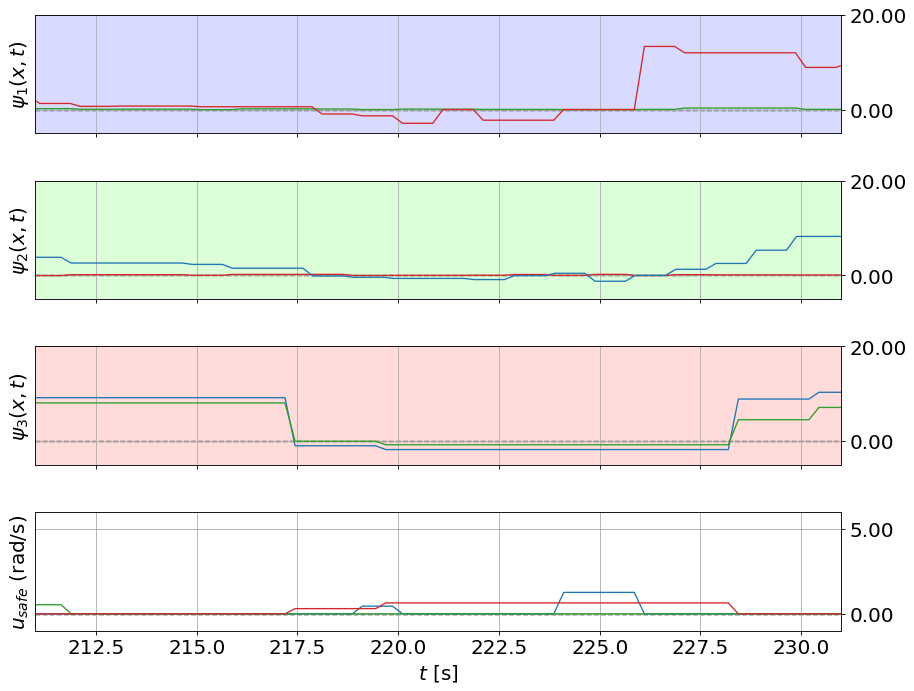

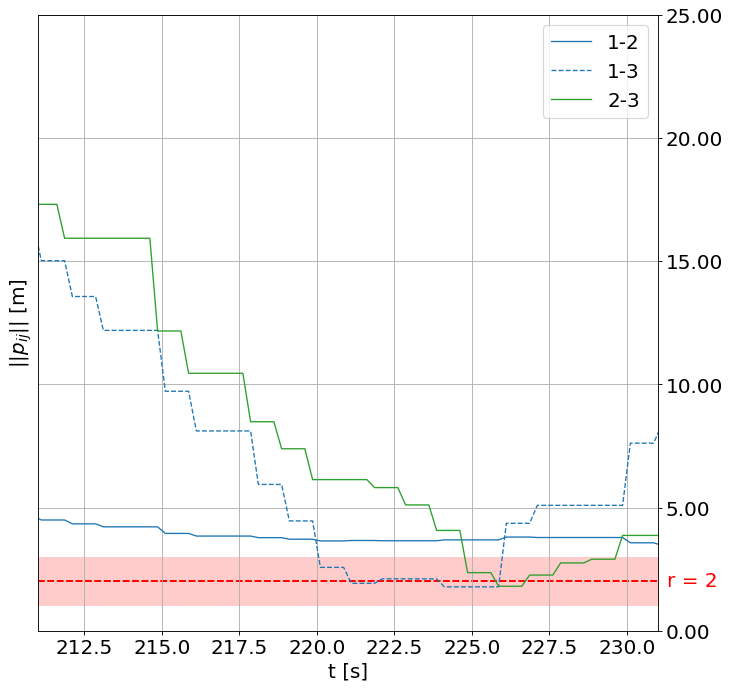

In [11]:
t = 231
plot_log(t-20,t,20)
plot_prel(t-20,t)

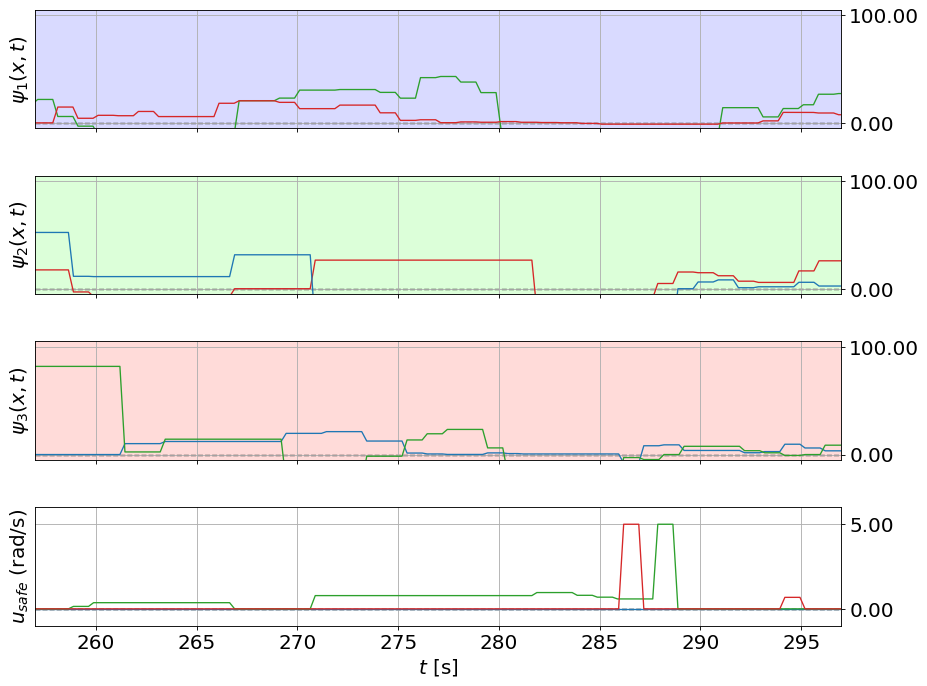

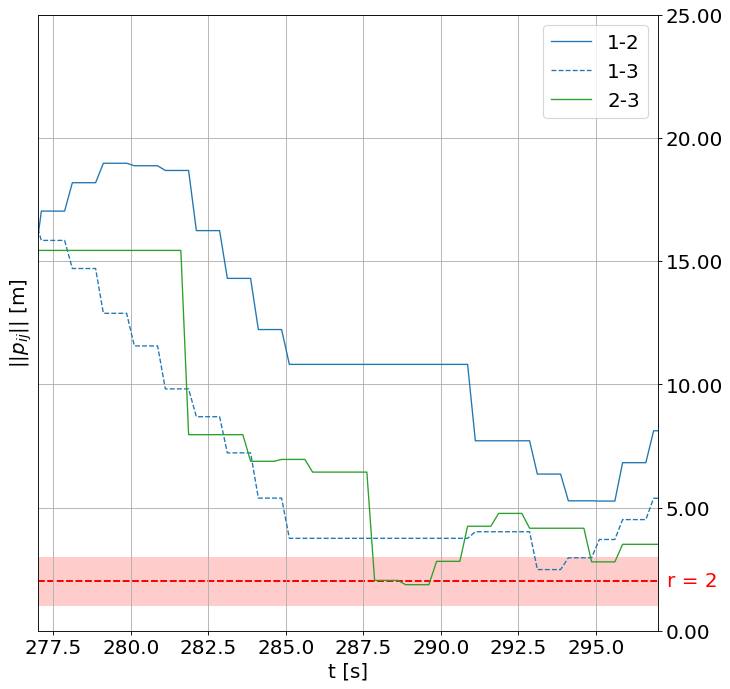

In [12]:
t = 297
plot_log(t-40,t)
plot_prel(t-20,t)

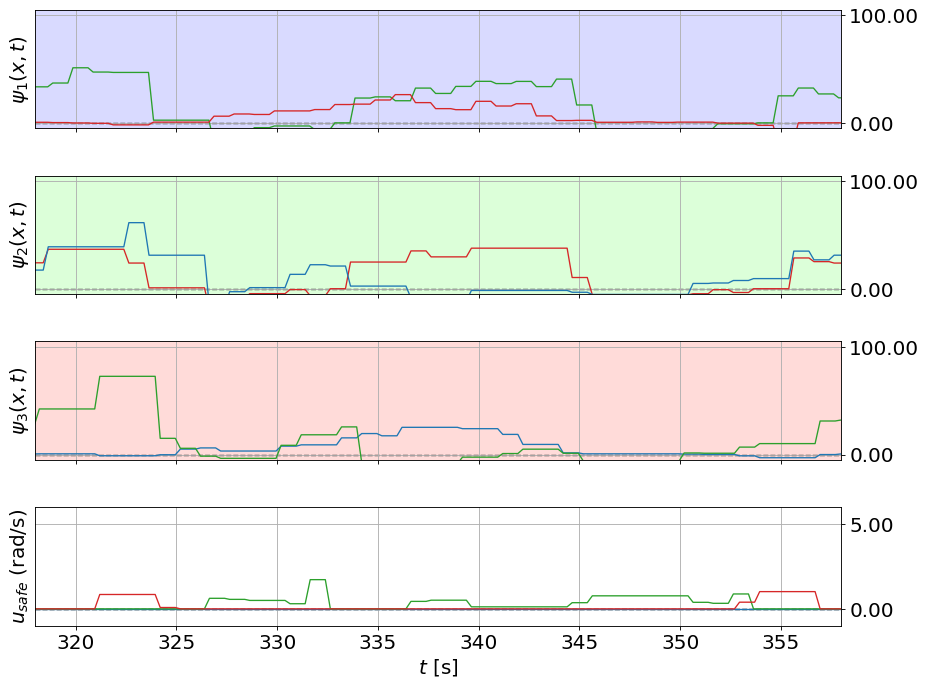

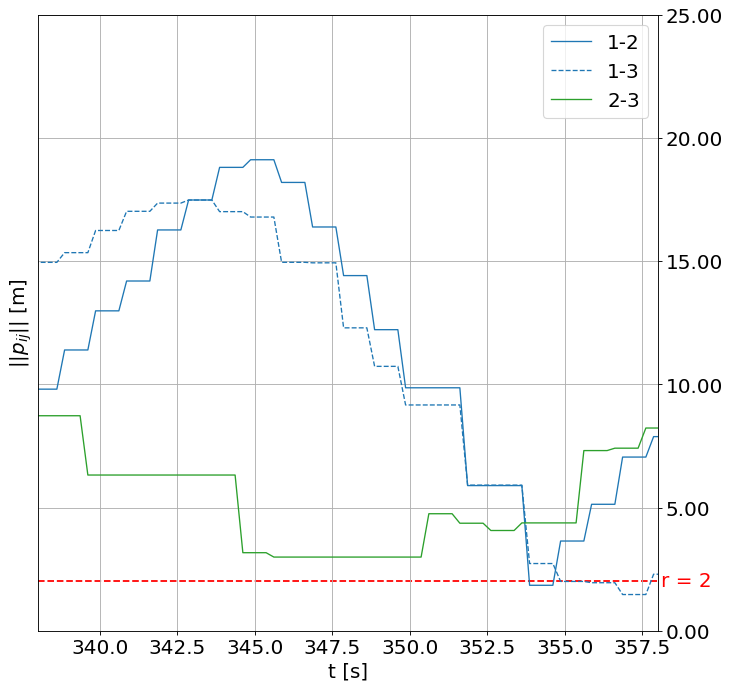

In [94]:
t = 358
plot_log(t-40,t)
plot_prel(t-20,t)

# Distance between robots during the whole simulation

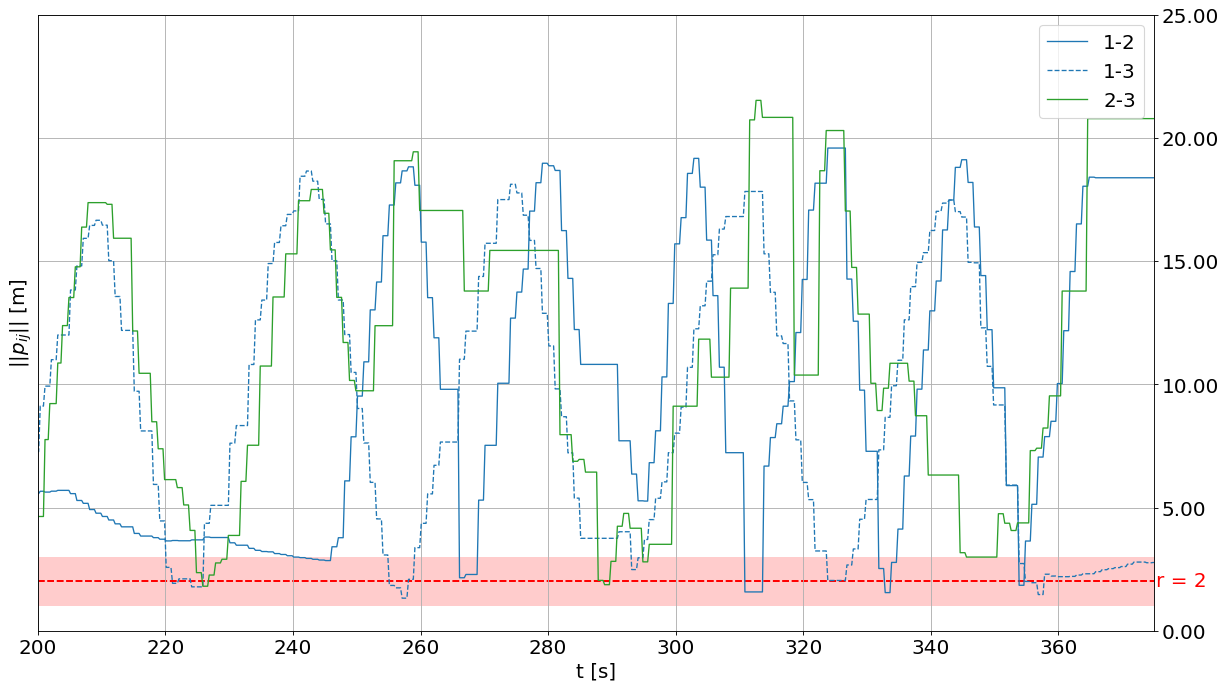

In [10]:
plot_prel(200,375,(18,10))